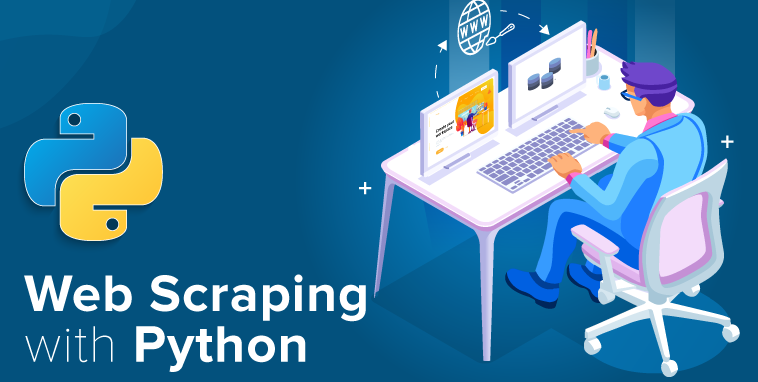

In [532]:
from IPython.display import Image,Markdown, display
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'
Image(r"D:\Sunny_Personal\OSU MSBA\Fall 2019\BehaviouralLab\web_scraping.png")

### <font color="maroon"> Importing the CEOs for whom the donations needs to be scraped </font>

In [406]:
import os
import numpy as np
import re
import pandas as pd
import datetime
import warnings
warnings.filterwarnings("ignore")

os.chdir("D:\Sunny_Personal\OSU MSBA\Fall 2019\BehaviouralLab")
os.getcwd()

'D:\\Sunny_Personal\\OSU MSBA\\Fall 2019\\BehaviouralLab'

In [533]:
#Importing the data
CEO_master=pd.read_csv("CEOs.csv")

#Number of CEOs#
print('The Number of CEOs to extract are '+str(CEO_master.Name.nunique()))

#Unique CEO list
CEO_unique=CEO_master.Name.unique()

The Number of CEOs to extract are 260


In [422]:
#Creating a dataframe of unique CEO list
CEO_unique_pd=pd.DataFrame(CEO_unique,columns=['Name'])

#Removing Special Characters 
CEO_unique_pd['Name_clean'] = CEO_unique_pd['Name'].map(lambda x: re.sub(r'\W+', ' ', x))

#Indexing for tagging the donations
CEO_unique_pd.index=range(1,1714)
CEO_unique_pd.reset_index(inplace=True)

#Splitting the Name into first Name and Last Name
CEO_unique_pd['FirstName']=CEO_unique_pd['Name_clean'].str.split(' [A-Z] ').str[0]
CEO_unique_pd['LastName']=CEO_unique_pd['Name_clean'].str.split(' [A-Z] ').str[1]

#Checking if there are more than one word in first name and lst name
CEO_unique_pd['FirstName_word_count']=CEO_unique_pd['FirstName'].str.split().apply(len)
CEO_unique_pd['LastName_word_count']=CEO_unique_pd['LastName'].str.split().apply(len)


#Validating the records
CEO_unique_pd_batch1=CEO_unique_pd[(CEO_unique_pd['FirstName_word_count']==1) & 
               (CEO_unique_pd['LastName_word_count']==1)]

print(CEO_unique_pd_batch1.shape)
CEO_unique_pd_batch1.head()

(1523, 7)


,index,Name,Name_clean,FirstName,LastName,FirstName_word_count,LastName_word_count
0,1,William J. Cadogan,William J Cadogan,William,Cadogan,1,1
1,2,Richard R. Roscitt,Richard R Roscitt,Richard,Roscitt,1,1
2,3,Robert E. Switz,Robert E Switz,Robert,Switz,1,1
3,4,Donald J. Carty,Donald J Carty,Donald,Carty,1,1
4,5,Gerard J. Arpey,Gerard J Arpey,Gerard,Arpey,1,1


### <font color="maroon"> Creating URL
    
       * Concatenating firstName and LastName with + 
       * Converting it to list

In [423]:
CEO_unique_pd_batch1['token']=CEO_unique_pd_batch1['LastName'].map(str)+'+'+CEO_unique_pd_batch1['FirstName'].map(str)

In [426]:
#converting to a list
CEO_list=CEO_unique_pd_batch1['token'].tolist()

In [463]:
#Creating a dictionary
#Since each page contains 50 records
#1 page has to be loaded if number of observations are between 0 and 50
#2 pages has to be loaded if number of observations are between 51 and 100
records_pages_dict = dict(
                    [(n,1) for n in range(1, 51)] +
                    [(n,2) for n in range(51, 101)] +
                    [(n,3) for n in range(101, 151)]+
                    [(n,4) for n in range(151, 201)]+
                    [(n,5) for n in range(201, 251)]+
                    [(n,6) for n in range(251, 301)]+
                    [(n,7) for n in range(301, 351)]+
                    [(n,8) for n in range(351, 401)]+
                    [(n,9) for n in range(401, 451)]+
                    [(n,10) for n in range(451,1001)]+
                    [(n,11) for n in range(1001,10001)]
                    )

### Web - Scraping using Selenium and Beautiful Soup

In [503]:
from selenium import webdriver
from bs4 import BeautifulSoup
import pandas as pd
import time
from requests.packages.urllib3.exceptions import *

#Configure chrome driver#
driver = webdriver.Chrome("chromedriver")

#Donations and success failed logs
Donations=[]
success_failed_log=[]
url_in_progress=[]

for i in range(len(CEO_list)):
    #creating a url for the CEO
    url= 'https://www.opensecrets.org/donor-lookup/results?name='+CEO_list[i]
    
    #Sleep after every 10 iterations to avoid Connection Reset by the host
    
    if(i%10 ==0):
        print('Sleeping')
        time.sleep(20)
     
    #Step1: Finding out how many pages to load
    
    #getting the information from URL and converting to soup object
    
    try:
        driver.get(url)
        content = driver.page_source
        soup = BeautifulSoup(content)   
        
        try:
            #number of observations available for the CEO
            number_of_records=soup.find('div',
                                    {'class':'DonorLookupSplash--results u-richtext u-mt4'})\
                                    .find('span').text.\
                                    replace('.','').replace(',','')
        
        #if there are no records, it return Attribute Error
        #Handling it
        except AttributeError as e1:
            print(str(i) + str(CEO_list[i])+ " Attribute Error - No data Found")
            number_of_records=0
            continue
        
    #Getting the value(Number of pages to load ) using the dictionary
    number_of_pages=records_pages_dict.get(int(number_of_records))
    ####################################################################################
    #Step 2: Loading the pages
    ####################################################################################
    
    #If there are pages to load
    if(number_of_pages>0):
        for j in range(number_of_pages):
            url_update=url+'&page='+str(j)
            try:
                driver.get(url_update)
                content = driver.page_source
                soup = BeautifulSoup(content)
                table_rows = soup.find_all('tr')
                
                for tr in table_rows:
                    td = tr.find_all('td')
                    row = [tr.text for tr in td]
                    #appending index to the data 
                    donations=row+list([str(i+1)])+ list([str(number_of_pages)])+list([str(number_of_records)])
                    if row:
                        Donations.append(donations)
                        success_failed_log.append([1,str(CEO_list[i])])
                        print(str(i)+ ' Success')
    
    #If there are no pages to load
    else:
        print(str(i)+ 'No records found')
        success_failed_log.append([0,str(CEO_list[i])])

### Data Pre-Processing
    
        * Convert list to DataFrame
        * Drop records with Null Amount ( test records)
        * Extract Year
        * Convert amount to number for aggregation
        * Summarize the data at Donor,Year level

In [515]:
import datetime


Donations_df=pd.DataFrame(Donations,columns=['Category','Contributor','Occupation',
                                             'Date_of_Donation','Amount','Recepient','index',
                                             'numer_of_pages',
                                             'numeber_of_records'])

#dropping records with null amount 
Donations_df.dropna(subset=['Amount'],inplace=True)

#selecting columns
Donations_fin=Donations_df[['Amount','index']]


#Formatting Amount to Numeric
Donations_fin['Amount']=Donations_fin['Amount'].str.replace("$","")
Donations_fin['Amount']=Donations_fin['Amount'].str.replace(",","")
Donations_fin['Amount']=pd.to_numeric(Donations_fin['Amount'])

#Grouping the date by index
Donations_agg=Donations_fin.groupby(['index'])['Amount'].sum()
Donations_agg=Donations_agg.reset_index()

#Viewing the data
Donations_agg.info()
Donations_agg['index']=Donations_agg['index'].astype('int64')
Donations_agg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260 entries, 0 to 259
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   index   260 non-null    object
 1   Amount  260 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 4.2+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260 entries, 0 to 259
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   index   260 non-null    int64
 1   Amount  260 non-null    int64
dtypes: int64(2)
memory usage: 4.2 KB


### Tagging the Donations to the CEOs

In [518]:
CEO_data=CEO_unique_pd[['index','Name']]
merge_data=pd.merge(Donations_agg,CEO_data,left_on=['index'],right_on=['index'])

### Top 10 CEO Donors 

In [528]:
merge_data.sort_values(by=['Amount'],inplace=True,ascending=False)
print('The top 10 donors are')
merge_data.head(10)

The top 10 donors are


,index,Amount,Name
194,38,453687,Liam K. Griffin
72,168,419600,Joseph W. McGrath
148,240,349500,Ronald L. Turner
190,33,336807,Darius E. Adamczyk
19,117,333733,"Harry M. Jansen Kraemer, Jr."
229,70,302021,Anthony G. Petrello
217,59,283066,Frank S. Hermance
61,158,268125,"Charles A. Heimbold, Jr."
59,156,246998,John S. Shiely
208,50,210500,John R. Stafford


### Exporting the file to local system

In [529]:
merge_data.to_csv(r'D:\Sunny_Personal\OSU MSBA\Fall 2019\BehaviouralLab\Tagged_donations.csv')